In [1]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam
from keras.datasets import fashion_mnist, mnist, cifar10, cifar100
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from time import time

import random
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline       

Using TensorFlow backend.


In [60]:

class Layer(object):
    def __init__(self, units=128, activation = 'relu', dropout = 0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2
        
    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)
    
    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation
    
    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout
    
    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)
    
    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()
            
    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True
    
    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)
    
    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units,self.activation, self.dropout)

            
class Cromosome(object):
    
    def __init__(self, layers = []):
        assert type(layers)==list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        
    def cross(self, other_cromosome):
        new_layers = []
        
        if self.n_layers==0:
            return other_cromosome
        '''
        elif other_cromosome.n_layers==0:
            return self
        '''
        
        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i<n_intersection or i>=other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)
    
    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers<self.max_layers:
            self.layers.append(Layer())
            self.n_layers = len(self.layers)
            
    def compare(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True
    
    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep
    

class GeneticAlgorithm(object):
    
    def __init__(self,fitness_obj, generations=70, num_population=20, num_parents=0.3, mutation_prob=0.7):
        self.num_generations = generations
        self.pop_size = num_population
        self.prob_muta = mutation_prob
        if type(num_parents)==int:
            self.num_parents = num_parents
        else:
            self.num_parents = int(self.pop_size * num_parents)
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        self.Fitness = fitness_obj
        self.offspring_size = self.pop_size - self.num_parents
        self.history = np.empty((self.pop_size, self.num_generations + 1))
        self.history_fitness = {}
        self.fitness_reutilization = 0
        
    def create_random_indiv(self):
        n_layers = np.random.randint(0,2)
        layers = []
        for i in range(n_layers):
            units = np.random.randint(0,512)
            act = random.choice(self.posible_activations)
            drop = np.random.rand()
            layers.append(Layer(units, act, drop))
        return Cromosome(layers)
    
    def create_simple_indiv(self):
        return Cromosome([])
    
    def initial_population(self):
        population = []
        for i in range(0, self.pop_size):
            population.append(self.create_simple_indiv())
        return population
    
    def rank(self, population):
        fitness_result = {}
        for i in range(self.pop_size):
            gen = "%s" % population[i]
            if not gen in self.history_fitness.keys():
                self.history_fitness[gen] = self.Fitness.calc(population[i])
            else:
                self.fitness_reutilization += 1
            fitness_result[i] = self.history_fitness[gen]
        return sorted(fitness_result.items(), key = operator.itemgetter(1), reverse = True)
    
    def select_mating_pool(self, population, rank):
        parents = []
        for i in range(self.num_parents):
            parent_num = rank[i][0]
            parents.append(population[parent_num])
        return parents
    
    def crossover(self, parents, offspring_size):
        offspring = []
        for k in range(offspring_size):
            p1 = np.random.randint(0, len(parents) - 1)
            p2 = np.random.randint(p1 + 1, len(parents))
            parent1 = parents[p1]
            parent2 = parents[p2]
            #parent1 = random.choice(parents)
            #parent2 = random.choice(parents)
            offspring.append(parent1.cross(parent2))
        return offspring
    
    def mutation(self, offspring_crossover):
        for crom in offspring_crossover:
            crom.mutate()
        return offspring_crossover
    
    def actualize_history(self, generation, rank):
        for i in range(len(rank)):
            self.history[i, generation] = rank[i][1]
    
    def show_history(self):
        x = np.linspace(0, self.num_generations, self.num_generations + 1)
        mean = np.mean(self.history, axis=0)
        max_ = np.max(self.history, axis=0)
        min_ = np.min(self.history, axis=0)
        plt.plot(x, mean, label="mean", color='r', lw=1)
        plt.plot(x, max_, label='max', color='b', lw=1)
        plt.plot(x, min_, label='min', color='g', lw=1)
        plt.legend()
        plt.xlabel("num generation")
        plt.ylabel('Fitness')
        plt.show()
    
    def evolve(self, show=True):
        population = self.initial_population()
        for generation in range(self.num_generations + 1):
            ranking = self.rank(population)
            self.actualize_history(generation, ranking)
            if self.num_generations<=10 and show:
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            elif show and (generation % int(self.num_generations / 10) == 0):
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            if generation == self.num_generations:
                break

            # Selecting the best parents in the population for mating.
            parents = self.select_mating_pool(population, ranking)

            # Generating next generation using crossover.
            offspring_crossover = self.crossover(parents, self.offspring_size)

            # Adding some variations to the offsrping using mutation.
            offspring_mutation = self.mutation(offspring_crossover)

            # Creating the new population based on the parents and offspring.
            population[0:self.num_parents] = parents
            population[self.num_parents:] = offspring_mutation
            
        ranking = self.rank(population)
        win_idx = ranking[0][0]
        best_fit = ranking[0][1]
        winner = population[win_idx]
        if show:
            print("Best Gen -> ", winner)
            print("With Fitness: %0.3f" % best_fit)
            print("Number of reutilization fitness: %d" % self.fitness_reutilization)
            self.show_history()
        return winner, best_fit

    
class Fitness_str():
    
    def __init__(self, crom_objective):
        self.crom = crom_objective
        self.str = "%s" % self.crom
        
    def calc(self, crom):
        C_str = "%s" % crom
        min_lenght = min(len(C_str), len(self.str))
        max_lenght = max(len(C_str), len(self.str))
        f = max_lenght - min_lenght
        for i in range(min_lenght):
            f += self.str[i] != C_str[i]
        return f
    

        

In [ ]:
l = Layer(758, 'elu', 0.86)
l2 = Layer(32, 'prelu', 0.32)
l3 = Layer(128, 'relu', 0.5)
c = Cromosome([l,l2, l3])

In [ ]:
ga = GeneticAlgorithm(Fitness_str(c), generations=1200, num_population=7, num_parents=0.2)

win, fit = ga.evolve()

In [ ]:
print(c)
print(win)

### Data Manager

This database administrator allows to use a subset of the complete database, that is, to select a more limited number of training examples or a smaller number of classes.

In [45]:

class DataManager(object):
    
    def __init__(self, name='mnist', max_examples=None, clases=[],  num_clases=10, train_split=0.8):
        assert name in ['mnist', 'fashion_mnist', 'cifar10', 'cifar100']
        self.name = name
        if len(clases) > 0:
            self.num_clases = len(clases)
        else: 
            self.num_clases = num_clases
        self.max_examples = max_examples
        self.clases = clases
        self.train_split = train_split
        
    def load_data(self):
        if self.name == 'mnist':
            data = mnist.load_data()
        elif self.name == 'fashion_mnist':
            data = fashion_mnist.load_data()
        elif self.name == 'cifar10':
            data = cifar10.load_data()
        else:
            data = cifar100.load_data()
            
        train_data, test_data = self.select_clases(data) 
        x_train, y_train = self.limit_examples(train_data)
        x_test, y_test = test_data

        del data, test_data, train_data
        
        x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
        x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

        y_train, y_test = self.encode(y_train, y_test)        
        y_train = to_categorical(y_train, self.num_clases)
        y_test = to_categorical(y_test, self.num_clases)
        
        (x_train, y_train), (x_val, y_val) = self.split(x_train, y_train, self.train_split)
        self.x_train = x_train
        self.x_test = x_test
        self.x_val = x_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
        print(x_train.shape, 'train samples')
        print(x_val.shape, 'validation samples')
        print(x_test.shape, 'test samples')
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val)
        
    def encode(self, y_train, y_test):
        self.encoder = {}
        self.decoder = {}
        clases = sorted(self.count_clases(y_train))
        for i in range(len(clases)):
            self.encoder[clases[i]] = i
            self.decoder[i] = clases[i]
            
        y_train = [self.encoder[l] for l in y_train]
        y_test = [self.encoder[l] for l in y_test]
        return y_train, y_test
            
        
    def limit_examples(self, data):
        examples = len(data[1])
        if self.max_examples is None or examples < self.max_examples:
            return data
        ids = np.random.permutation(examples)
        return (data[0][ids[:self.max_examples]], data[1][ids[:self.max_examples]])
        
    
    def select_clases(self, data):
        data_clases = self.count_clases(data[0][1])
        if len(data_clases) <= self.num_clases:
            self.num_clases = len(data_clases)
            return data
        if len(self.clases) == 0:
            all_clases = np.random.permutation(len(data_clases))
            sel_id = all_clases[:self.num_clases]
            sel = data_clases[sel_id]
        else:
            sel = self.clases
        idx_train = np.array([i for i in range(len(data[0][1])) if data[0][1][i] in sel])
        idx_test = np.array([i for i in range(len(data[1][1])) if data[1][1][i] in sel])
        return (data[0][0][idx_train], data[0][1][idx_train]), (data[1][0][idx_test], data[1][1][idx_test])
            
        
    def count_clases(self, labels):
        classes = []
        for label in labels:
            if not label in classes:
                classes.append(label)
        return np.array(classes)
        
    def decode(self, onehot_labels):
        decoded_labels = []
        if onehot_labels.ndim == 2:
            n_ex, n_clases = onehot_labels.shape
            for i in range(n_ex):
                decoded_labels.append(self.decoder[np.argmax(onehot_labels[i])])
        else:
            decoded_labels.append(self.decoder[np.argmax(onehot_labels)])
        return np.array(decoded_labels)
    
    def split(self, data, labels, train_split):
        idx = np.random.permutation(data.shape[0])
        s = int(train_split * data.shape[0])
        return (data[:s], labels[:s]), (data[s:], labels[s:])


In [27]:
dm = DataManager(clases=[4,9])
(x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()

(60000, 28, 28)
(11791, 28, 28) train samples
(1991, 28, 28) test samples
(11791, 28, 28, 1) train samples
(1991, 28, 28, 1) test samples
9432
(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples


In [15]:
print(x_train.shape, x_test.shape, x_val.shape)

print(y_train.shape, y_test.shape, y_val.shape)

(9432, 28, 28, 1) (1991, 28, 28, 1) (9432, 28, 28, 1)
(9432, 2) (1991, 2) (9432, 2)


In [ ]:
for i in range(20):
    plt.imshow(x_val[i].reshape(28,28), cmap='gray')
    plt.title(dm.decode(y_val[i,:]))
    plt.show()

### Training a single Net

In [54]:
class Fitness():
    
    def __init__(self, data, num_clases, batch_size=128, epochs=100, early_stop=True, reduce_plateu=True, verbose=1):
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateu
        self.num_clases = num_clases
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.callbacks = []
        if self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=self.verb))
        
    def calc(self, chromosome):
        model = self.decode(chromosome)
        h = model.fit(self.x_train, self.y_train,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    verbose=self.verb,
                    validation_data=(self.x_val, self.y_val),
                    callbacks = self.callbacks)
        score = model.evaluate(self.x_val, self.y_val, verbose=0)
        if self.verb:
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        return score[1]
    
    
    ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
    
    def decode(self, chromosome):
        
        inp = Input(shape=(28,28,1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)
        
        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
        return model
    
    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s'%metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()
            

In [58]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
l3 = Layer(128, 'relu', 0.5)
c = Cromosome([l,l2, l3])
c = Cromosome([l, l2])
clases = [4, 9]
dm = DataManager(clases=clases)
data = dm.load_data()

fitness = Fitness(data, len(clases), verbose=0)

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_89 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 516)               405060    
_________________________________________________________________
dropout_100 (Dropout)        (None, 516)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 516)               266772    
_________________________________________________________________
dropout_101 (Dropout)        (None, 516)               0         
_________________________________________________________________
dense_189 (Dense)            (None, 2)                 1034      
Total para

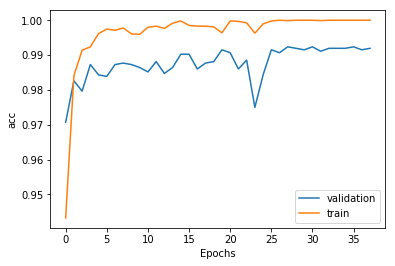

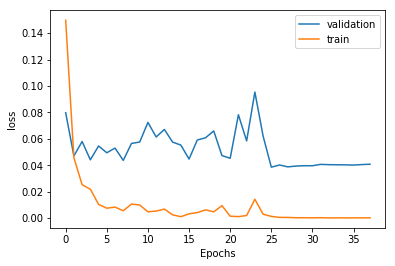

Time elapsed: 23.684


In [56]:
ti = time()
fitness.calc(c)
print("Time elapsed: %0.3f" % (time() - ti))

U:32|A:prelu|D:0.320
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
Train on 9432 samples, validate on 2359 samples
Epoch 1/100
9432/9432 [==============================] - 1s 59us/step - loss: 0.4614 - acc: 0.8242 - val_loss: 0.2985 - val_acc: 0.9309
Epoch 2/100
9432/9432 [==============================] - 0s 20us/step - loss: 0.2585 - acc: 0.9400 - val_loss: 0.2069 - val_acc: 0.9487
Epoch 3/100
9432/9432 [==============================] - 0s 20u

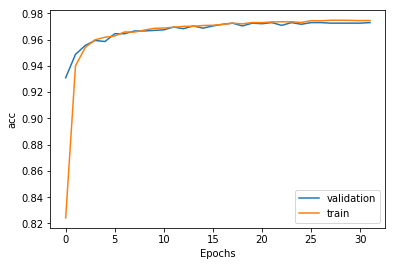

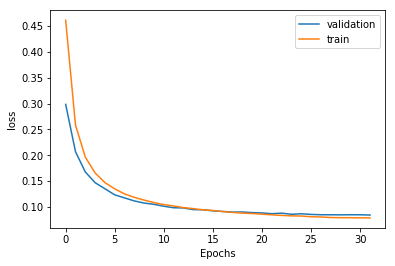

Time elapsed: 7.420


In [37]:
ti = time()
print(l2)
fitness.calc(Cromosome([]))
print("Time elapsed: %0.3f" % (time() - ti))

1) best fit: 0.972
2) best fit: 0.972
3) best fit: 0.972
4) best fit: 0.990
5) best fit: 0.990
Best Gen ->  0 - U:350|A:relu|D:0.000 

With Fitness: 0.990
Number of reutilization fitness: 54


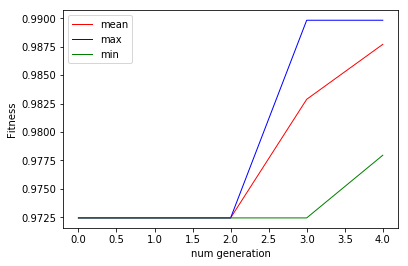

In [61]:
ga = GeneticAlgorithm(fitness, generations=4, num_population=10, num_parents=0.4)

win, fit = ga.evolve()

In [48]:
d = ga.history_fitness

In [51]:
for k in d.keys():
    print(k)


0 - U:318|A:relu|D:0.183 

0 - U:318|A:relu|D:0.687 

0 - U:123|A:relu|D:0.183 

0 - U:225|A:sigmoid|D:0.183 

0 - U:411|A:relu|D:0.183 

0 - U:318|A:relu|D:0.137 

0 - U:318|A:prelu|D:0.183 

0 - U:855|A:relu|D:0.183 

0 - U:318|A:relu|D:0.684 

0 - U:318|A:relu|D:0.193 

0 - U:318|A:leakyreLu|D:0.183 

0 - U:564|A:relu|D:0.514 

0 - U:280|A:elu|D:0.400 

0 - U:318|A:leakyreLu|D:0.440 

0 - U:828|A:relu|D:0.687 

0 - U:83|A:prelu|D:0.662 

0 - U:117|A:tanh|D:0.687 

0 - U:327|A:prelu|D:0.826 

0 - U:318|A:prelu|D:0.210 

0 - U:575|A:relu|D:0.687 

0 - U:429|A:prelu|D:0.521 

0 - U:445|A:tanh|D:0.405 

0 - U:318|A:prelu|D:0.417 

0 - U:534|A:relu|D:0.517 

0 - U:484|A:relu|D:0.328 

0 - U:561|A:relu|D:0.498 

0 - U:799|A:relu|D:0.132 

0 - U:453|A:prelu|D:0.253 

0 - U:564|A:relu|D:0.795 

0 - U:535|A:relu|D:0.575 

0 - U:201|A:relu|D:0.515 

0 - U:527|A:elu|D:0.547 

0 - U:252|A:relu|D:0.514 

0 - U:558|A:sigmoid|D:0.325 
1 - U:128|A:relu|D:0.000 

0 - U:320|A:relu|D:0.255 

0 - U:43